## Spleen Model Without NVIDIA Pretrain

#### 
- Using same Unet model
- Same number of Epochs
- Using randomly initialized model

In [24]:
%matplotlib inline

In [25]:
import os
import tempfile
import glob

import matplotlib.pyplot as plt
import torch
import numpy as np

from monai.apps import download_and_extract
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceFocalLoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import (
    LMDBDataset,
    DataLoader,
    decollate_batch,
    ImageDataset,
    Dataset
)
from monai.apps import load_from_mmar
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    LoadImaged,
    ScaleIntensityRanged,
    Spacingd,
    Orientationd,
    CropForegroundd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotated,
    EnsureType,
    EnsureTyped,
)
from monai.utils import set_determinism
from monai.apps.mmars import RemoteMMARKeys

In [26]:
PRETRAINED = False

In [27]:
directory = "monai_data/"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

monai_data/


In [28]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
download_and_extract(resource, compressed_file, root_dir, md5)
data_dir = os.path.join(root_dir, "Task09_Spleen")

Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
File exists: monai_data/Task09_Spleen.tar, skipped downloading.
Non-empty folder exists in monai_data/Task09_Spleen, skipped extracting.


In [29]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [30]:
train_files

[{'image': 'monai_data/Task09_Spleen/imagesTr/spleen_10.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_10.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_12.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_12.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_13.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_13.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_14.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_14.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_16.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_16.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_17.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_17.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_18.nii.gz',
  'label': 'monai_data/Task09_Spleen/labelsTr/spleen_18.nii.gz'},
 {'image': 'monai_data/Task09_Spleen/imagesTr/spleen_19.nii.gz',
  'label': 'monai_

In [31]:
train_transforms = Compose( #Transformations for training dataset
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=0.5,
            spatial_size=(96, 96, 96),
            rotate_range=(np.pi/18, np.pi/18, np.pi/5),
            scale_range=(0.05, 0.05, 0.05)
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose( #Transformations for testing dataset
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        RandRotated(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            range_x=np.pi/18,
            range_y=np.pi/18,
            range_z=np.pi/5,
            prob=1.0,
            padding_mode=('reflection', 'reflection'),
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

In [32]:
train_ds = LMDBDataset(data=train_files, transform=train_transforms, cache_dir=root_dir)
# initialize cache and print meta information
print(train_ds.info())

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

# the validation data loader will be created on the fly to ensure 
# a deterministic validation set for demo purpose.
val_ds = LMDBDataset(data=val_files, transform=val_transforms, cache_dir=root_dir)
# initialize cache and print meta information
print(val_ds.info())

100%|██████████| 32/32 [00:00<00:00, 37056.25it/s]


Accessing lmdb file: /home/jupyter/covid19det-kaggle/kaggle/monai_data/monai_cache.lmdb.


100%|██████████| 32/32 [00:00<00:00, 40305.62it/s]


{'map_addr': 0, 'map_size': 1099511627776, 'last_pgno': 941102, 'last_txnid': 100, 'max_readers': 126, 'num_readers': 0, 'size': 32, 'filename': '/home/jupyter/covid19det-kaggle/kaggle/monai_data/monai_cache.lmdb'}


100%|██████████| 9/9 [00:00<00:00, 17484.36it/s]


Accessing lmdb file: /home/jupyter/covid19det-kaggle/kaggle/monai_data/monai_cache.lmdb.


100%|██████████| 9/9 [00:00<00:00, 29723.41it/s]

{'map_addr': 0, 'map_size': 1099511627776, 'last_pgno': 941102, 'last_txnid': 100, 'max_readers': 126, 'num_readers': 0, 'size': 9, 'filename': '/home/jupyter/covid19det-kaggle/kaggle/monai_data/monai_cache.lmdb'}


In [33]:
print(train_ds.info())

{'map_addr': 0, 'map_size': 1099511627776, 'last_pgno': 941102, 'last_txnid': 100, 'max_readers': 126, 'num_readers': 0, 'size': 32, 'filename': '/home/jupyter/covid19det-kaggle/kaggle/monai_data/monai_cache.lmdb'}


In [34]:
mmar = {
    RemoteMMARKeys.ID: "clara_pt_spleen_ct_segmentation_1",
    RemoteMMARKeys.NAME: "clara_pt_spleen_ct_segmentation",
    RemoteMMARKeys.FILE_TYPE: "zip",
    RemoteMMARKeys.HASH_TYPE: "md5",
    RemoteMMARKeys.HASH_VAL: None,
    RemoteMMARKeys.MODEL_FILE: os.path.join("models", "model.pt"),
    RemoteMMARKeys.CONFIG_FILE: os.path.join("config", "config_train.json"),
    RemoteMMARKeys.VERSION: 1,
}

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if PRETRAINED:
    print("using a pretrained model.")
    unet_model = load_from_mmar(
        mmar, mmar_dir=root_dir,
        map_location=device,
        pretrained=True)
    model = unet_model
else:
    print("using a randomly init. model.")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    )
model = model.to(device)

using a randomly init. model.


In [36]:
test_file = data_dicts[20:21]
test_ds = LMDBDataset(data=test_file, transform=None, cache_dir=root_dir)

100%|██████████| 1/1 [00:00<00:00, 6842.26it/s]

Accessing lmdb file: /home/jupyter/covid19det-kaggle/kaggle/monai_data/monai_cache.lmdb.


In [37]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])
model.eval()
with torch.no_grad():
    for data in DataLoader(test_ds, batch_size=1, num_workers=2):
        test_inputs, test_labels = (
                        data["image"].to(device),
                        data["label"].to(device),
                    )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.5)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]

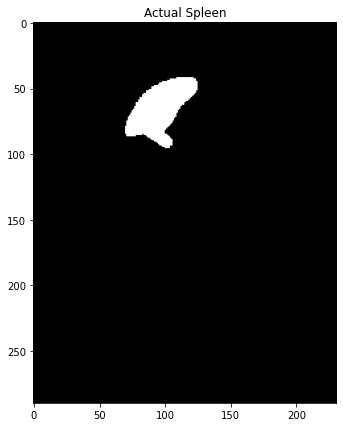

In [38]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Actual Spleen')
plt.imshow(test_labels[0].cpu().numpy()[1][:,:,200], cmap='Greys_r') #Actual spleen

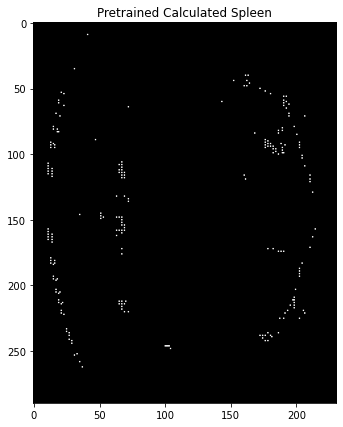

In [39]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Pretrained Calculated Spleen')
plt.imshow(test_outputs[0].cpu().numpy()[1][:,:,200], cmap='Greys_r') #Pretrained model spleen

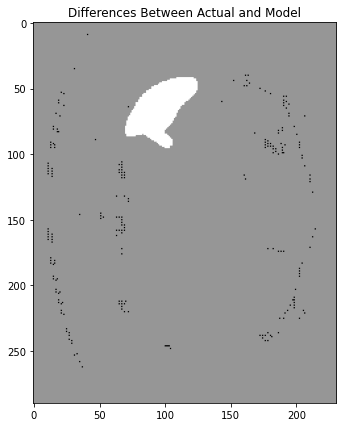

In [40]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Differences Between Actual and Model')
pretraineddif = test_labels[0].cpu().numpy()[1][:,:,200] - test_outputs[0].cpu().numpy()[1][:,:,200]
plt.imshow(pretraineddif, cmap='Greys_r') #Differences

In [41]:
loss_function = DiceFocalLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 5e-4)

In [ ]:
max_epochs = 25
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    set_determinism(seed=42)
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            set_determinism(seed=42)
            for val_data in DataLoader(val_ds, batch_size=1, num_workers=2):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model, overlap=0.5)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/25
1/16, train_loss: 0.9791
2/16, train_loss: 0.9552
3/16, train_loss: 0.9070
4/16, train_loss: 0.8837
5/16, train_loss: 0.8578
6/16, train_loss: 0.8361
7/16, train_loss: 0.8458
8/16, train_loss: 0.8164
9/16, train_loss: 0.8009
10/16, train_loss: 0.8321
11/16, train_loss: 0.8021
12/16, train_loss: 0.8085
13/16, train_loss: 0.7986
14/16, train_loss: 0.7759
15/16, train_loss: 0.8061
16/16, train_loss: 0.7834
epoch 1 average loss: 0.8430
----------
epoch 2/25
1/16, train_loss: 0.7855
2/16, train_loss: 0.7885
3/16, train_loss: 0.7658
4/16, train_loss: 0.7501
5/16, train_loss: 0.7554
6/16, train_loss: 0.7135
7/16, train_loss: 0.7626
8/16, train_loss: 0.7287
9/16, train_loss: 0.7181
10/16, train_loss: 0.7702
11/16, train_loss: 0.7350
12/16, train_loss: 0.7545
13/16, train_loss: 0.7367
14/16, train_loss: 0.7047
15/16, train_loss: 0.7486
16/16, train_loss: 0.7253
epoch 2 average loss: 0.7465
saved new best metric model
current epoch: 2 current mean dice: 0.0231
best mean dic

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.ylim([0.1, 1.0])
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.ylim([0, 1.0])
plt.plot(x, y)
plt.show()

In [ ]:
model.load_state_dict(torch.load('monai_data/best_metric_model.pth'))

In [ ]:
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])
model.eval()
with torch.no_grad():
    for data in DataLoader(test_ds, batch_size=1, num_workers=2):
        test_inputs, test_labels = (
                        data["image"].to(device),
                        data["label"].to(device),
                    )
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model, overlap=0.5)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]

In [ ]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Actual Spleen')
plt.imshow(test_labels[0].cpu().numpy()[1][:,:,200], cmap='Greys') #Actual spleen

In [ ]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Model (random initialization) Calculated Spleen')
plt.imshow(test_outputs[0].cpu().numpy()[1][:,:,200], cmap='Greys') #Pretrained model spleen

In [ ]:
fig = plt.figure(frameon=False, figsize=(7,7))
plt.title('Differences Between Actual and Model')
traineddif = test_labels[0].cpu().numpy()[1][:,:,200] - test_outputs[0].cpu().numpy()[1][:,:,200]
plt.imshow(traineddif, cmap='Greys') #Differences

In [ ]:
fig = plt.figure(frameon=False, figsize=(10,10))
#plt.imshow(np.rot90(test_ds[0]['image'][0][:,:,200]), cmap='Greys_r')
plt.imshow(np.rot90(test_outputs[0].cpu().numpy()[1][:,:,200]), cmap='cividis', alpha=0.25)